<a href="https://colab.research.google.com/github/archie-sinha/Deep-Learning-with-PyTorch-GradCAM-Basic-Code/blob/main/Archi_Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ARCHISHA SINHA**

#Deep Learning with PyTorch  : GradCAM

---


# GradCAM - Gradient Class Activation Map

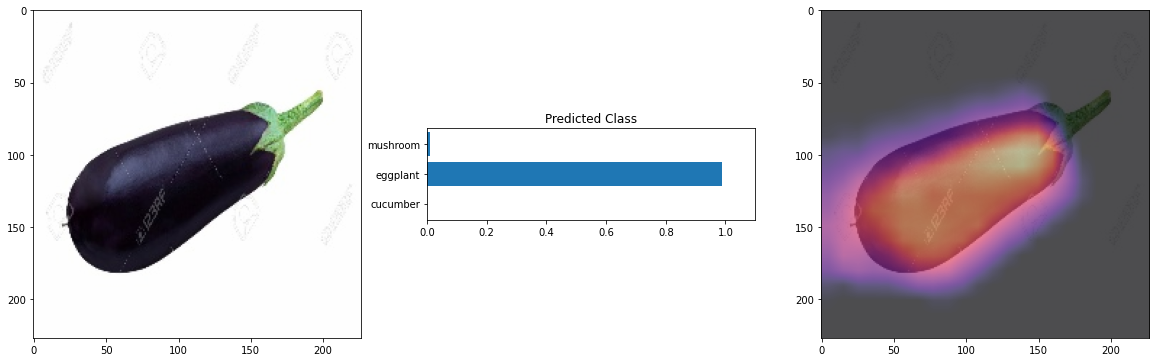

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 3.68 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1vzi0czl
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1vzi0czl
  Resolved https://github.com/albumentations-team/albumentations to commit f7f9596f6adf5e53bc15555fb264a065919773c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A # Data augeentation with PyTorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


Cucumber - Label 0

Eggplant - Label 1

Mushrooms - Label 2

In [6]:
train_df , valid_df = train_test_split(data, test_size= 0.2,random_state= 42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485,0.456,0.406],std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485,0.456,0.406],std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, augs= train_augs, data_dir= DATA_DIR)
validset = utils.ImageDataset(valid_df, augs= valid_augs, data_dir= DATA_DIR)

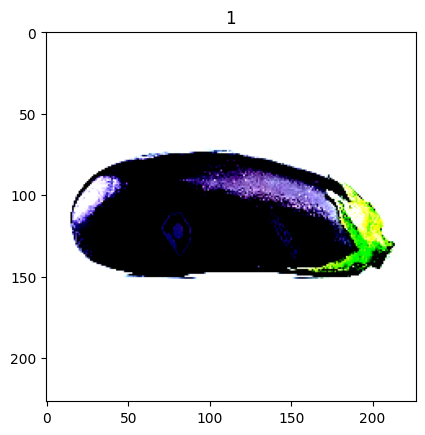

In [9]:
# image, label = trainset[0]    #by default the image is in the format of (chanel, height, width)
#                               # but we need to convert or permute it to (height, width, chanel)
# plt.imshow(image.permute(1,2,0))
# plt.title(label);


image, label = trainset[0] #(c,h,w) -> (h,w,c)

class_list = ['cucumber','eggplant','mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(label);

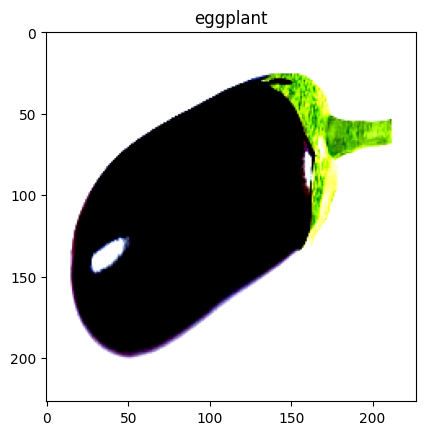

In [10]:
image, label = trainset[7]    #by default the image is in the format of (chanel, height, width)
                              # but we need to convert or permute it to (height, width, chanel)

class_list= ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [11]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


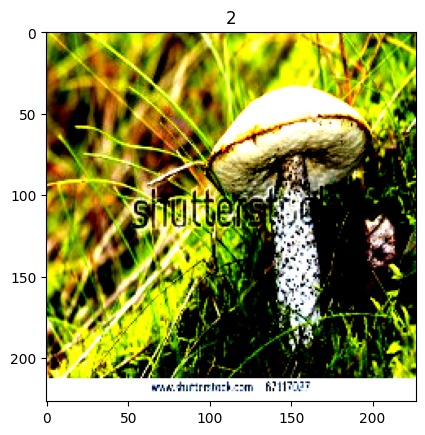

In [12]:
image, label = validset[21]    #by default the image is in the format of (chanel, height, width)
                              # but we need to convert or permute it to (height, width, chanel)
plt.imshow(image.permute(1,2,0))
plt.title(label);

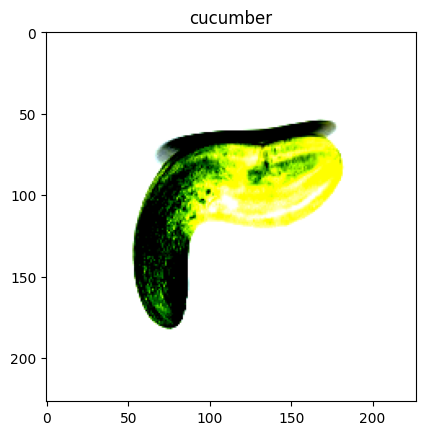

In [13]:
image, label = trainset[34]    #by default the image is in the format of (chanel, height, width)
                              # but we need to convert or permute it to (height, width, chanel)

class_list= ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


Let us see the shape of Images and labels:

In [16]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


**One batch image shape : torch.Size([16, 3, 227, 227])**

####-->Batchsize=16, Chanel =3, Height=227, Width=227


**One batch label shape : torch.Size([16])**

####-->Batchsize=16  (16 images so 16 labels in 1 batch)

# Create Model

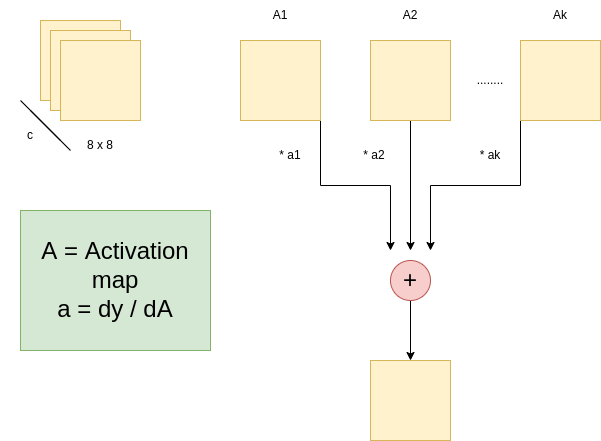

In [17]:
from torch.nn.modules.pooling import MaxPool2d

In [18]:
#from torch.nn.modules.pooling import MaxPool2d

class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size= (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (4,4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
    )

    self.maxpool = nn.MaxPool2d(kernel_size= (4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):

    x = self.feature_extractor(images) # activation_maps

    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): # a1, a2, a3... ak
    return self.gradient

  def get_activation(self, x):   #A1, A2, A3...Ak
    return self.feature_extractor(x)


In [19]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [20]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to('cpu')
    labels = labels.to('cpu')

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [21]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to('cpu')
    labels = labels.to('cpu')


    logits = model(images)
    loss = criterion(logits, labels)


    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHT_SUCCESS")

    print(f"EPOCH : {1 + 1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 31.78it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 1.1306739687919616 VALID LOSS : 0.9426948428153992


100%|██████████| 3/3 [00:00<00:00, 38.08it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.7609088659286499 VALID LOSS : 0.4965868294239044


100%|██████████| 3/3 [00:00<00:00, 39.58it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.3982220128178596 VALID LOSS : 0.4623982384800911


100%|██████████| 3/3 [00:00<00:00, 22.30it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.4862084940075874 VALID LOSS : 0.39854831993579865


100%|██████████| 3/3 [00:00<00:00, 30.16it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.27263529002666476 VALID LOSS : 0.34792085240284604


100%|██████████| 3/3 [00:00<00:00, 35.90it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.21812704317271708 VALID LOSS : 0.18258128811915716


100%|██████████| 3/3 [00:00<00:00, 37.02it/s]


SAVED_WEIGHT_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.13472257517278194 VALID LOSS : 0.17592010584970316


100%|██████████| 3/3 [00:00<00:00, 38.96it/s]


# Get GradCAM

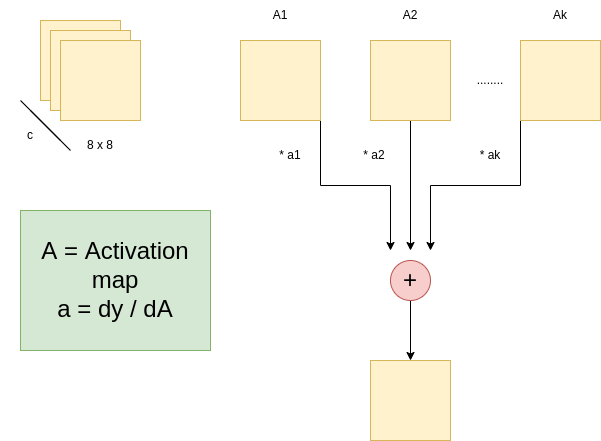

In [28]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients= model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=[0,2,3])     #a1, a2 .... ak
  activation= model.get_activation(image).detach()    #A1, A2 ..... Ak

  for i in range(activation.shape[1]):

    activation[:, i, :, : ] = activation[:, i, :, : ]*pooled_gradients


  heatmap = torch.mean (activation, dim=1).squeeze().cpu()
  heatmap = nn.ReLU() (heatmap)
  heatmap = heatmap/ torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

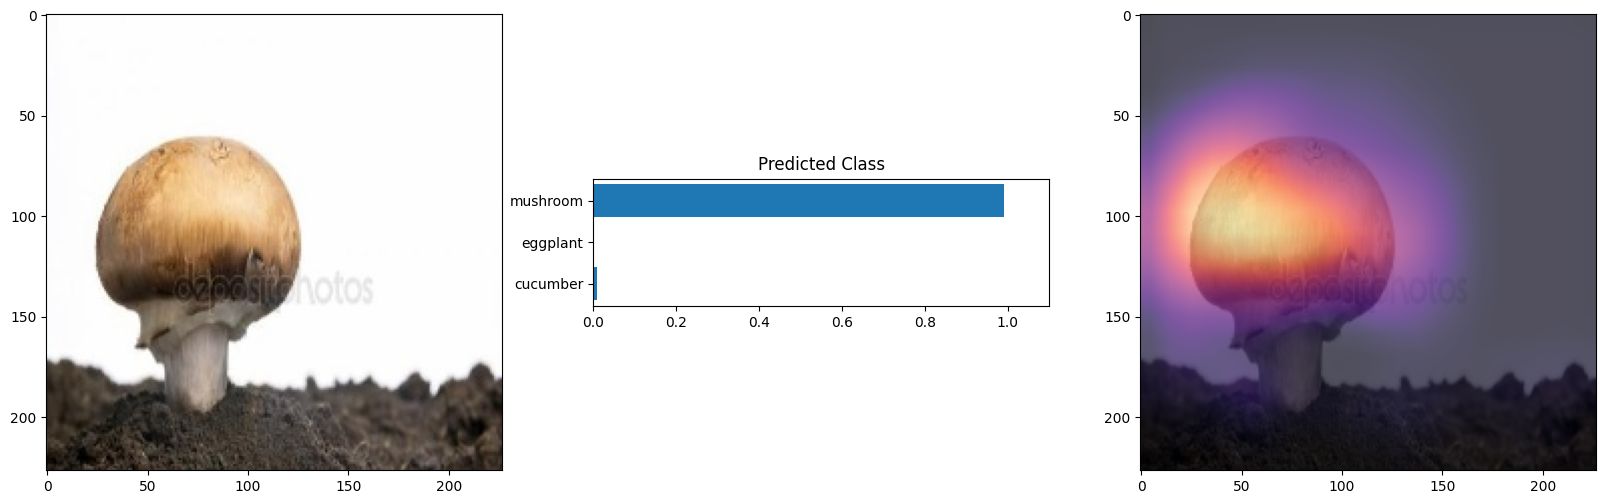

In [ ]:
image, label = validset[9]

denorm_image = image.permute(1,2,0) * np.array((0.229,0.224,0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][2], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)